In [1]:
import boto3
import os

from sagemaker import get_execution_role, Session

# Initialize a SageMaker session
sagemaker_session = Session()



role = "arn:aws:iam::016114370410:role/tf-binding-sites"

prefix = "inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/"
local_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"


# Initialize the S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket name
bucket_name = sagemaker_session.default_bucket()


# Function to download files from an S3 bucket
def download_from_s3(bucket_name, prefix, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    # List objects within the specified prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    # Iterate over each object
    for obj in response.get('Contents', []):
        key = obj['Key']
        # Skip if it's a folder
        if key.endswith('/'):
            continue
        local_path = os.path.join(local_dir, os.path.basename(key))
        
        # Download the file
        s3.download_file(bucket_name, key, local_path)
        print(f'Downloaded {key} to {local_path}')

# Bucket name extracted from the S3 URI
bucket_name = "tf-binding-sites"

# delete the files in local dir
for file in os.listdir(local_dir):
    os.remove(os.path.join(local_dir, file))
    

# Download the files
download_from_s3(bucket_name, prefix, "/Users/wejarrard/projects/tf-binding/data/jsonl_output")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/wejarrard/Library/Application Support/sagemaker/config.yaml
Downloaded inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/dataset_1.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_1.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/dataset_10.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_10.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/dataset_100.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_100.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/dataset_101.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_101.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/d

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt


# Path to the directory containing JSON files
json_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"

# Get a list of all JSON files in the directory
json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")

# Read each JSON file into a DataFrame and store in a list
dataframes = [pd.read_json(file) for file in json_files]

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

df

,chr_name,start,end,cell_line,targets,predicted,weights,probabilities,enhancer,promoter
0,chr17,68474329,68474711,A549,0,0,0,0.001130,0,0
1,chr17,68474442,68474704,HEK_293,0,0,0,0.000904,0,0
2,chr17,68485145,68486170,THP-1,0,0,0,0.014496,0,0
3,chr17,68485778,68486177,A549,0,0,0,0.013100,0,0
4,chr17,68490815,68492311,A549,0,0,0,0.000199,0,0
...,...,...,...,...,...,...,...,...,...,...
602250,chr6,100080548,100080721,THP-1,0,1,0,0.971720,0,0
602251,chr6,100088028,100088349,LNCAP,1,1,6,0.991871,0,0
602252,chr6,100088048,100088425,PC-3,0,1,0,0.983496,0,0
602253,chr6,100096399,100097117,THP-1,0,0,0,0.000234,0,0


In [3]:
# precision and recall
df['tp'] = (df['targets'] == 1) & (df['predicted'] == 1)
df['fp'] = (df['targets'] == 0) & (df['predicted'] == 1)
df['fn'] = (df['targets'] == 1) & (df['predicted'] == 0)
df['tn'] = (df['targets'] == 0) & (df['predicted'] == 0)

precision = df['tp'].sum() / (df['tp'].sum() + df['fp'].sum())
recall = df['tp'].sum() / (df['tp'].sum() + df['fn'].sum())

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# f1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 score: {f1:.2f}")

# accuracy
accuracy = (df['tp'].sum() + df['tn'].sum()) / len(df)
print(f"Accuracy: {accuracy:.2f}")


Precision: 0.29
Recall: 0.87
F1 score: 0.43
Accuracy: 0.81


False positives: 108668
False negatives: 6389
True positives: 44099
True negatives: 443099


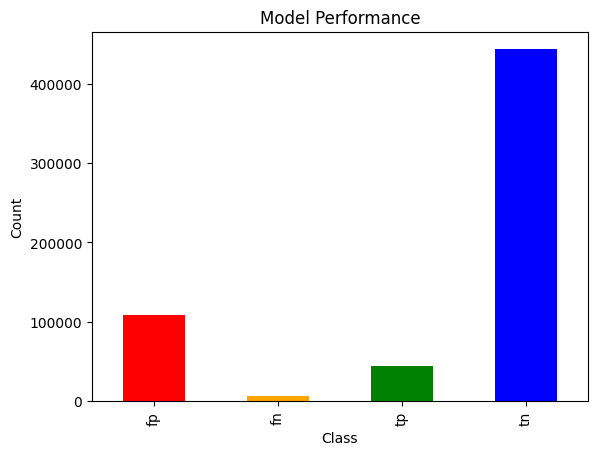

In [4]:
print(f"False positives: {df['fp'].sum()}")
print(f"False negatives: {df['fn'].sum()}")
print(f"True positives: {df['tp'].sum()}")
print(f"True negatives: {df['tn'].sum()}")

# plot false positives, false negatives, true positives, and true negatives
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot the number of false positives, false negatives, true positives, and true negatives and give it different colors
df[['fp', 'fn', 'tp', 'tn']].sum().plot(kind='bar', ax=ax, color=['red', 'orange', 'green', 'blue'])

# Add a title and labels
ax.set_title('Model Performance')
ax.set_ylabel('Count')
ax.set_xlabel('Class')

# Display the plot
plt.show()

In [5]:
# filter out for false positives
df_fp = df[df['fp'] == True]

# get average probability for false positives
avg_prob_fp = df_fp['probabilities'].mean()
print(f"Average probability for false positives: {avg_prob_fp:.2f}")
print(f"Number of false positives: {len(df_fp)}")

Average probability for false positives: 0.90
Number of false positives: 108668


In [6]:
# Average probability for true positives
df_tp = df[df['tp'] == True]
avg_prob_tp = df_tp['probabilities'].mean()
print(f"Average probability for true positives: {avg_prob_tp:.2f}")

Average probability for true positives: 0.96


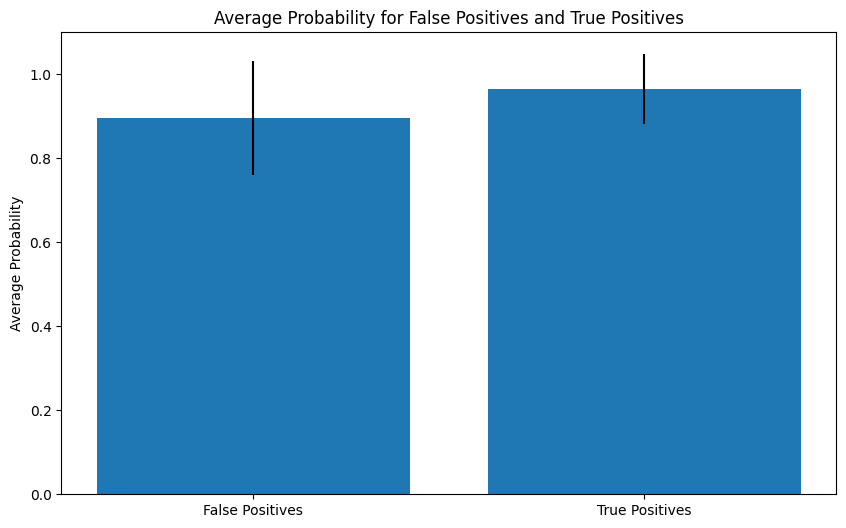

In [7]:
# Show bar plots with false positives and true positives and thier std


plt.figure(figsize=(10, 6))
plt.bar(['False Positives', 'True Positives'], [avg_prob_fp, avg_prob_tp], yerr=[df_fp['probabilities'].std(), df_tp['probabilities'].std()])
plt.ylabel('Average Probability')
plt.title('Average Probability for False Positives and True Positives')
plt.show()

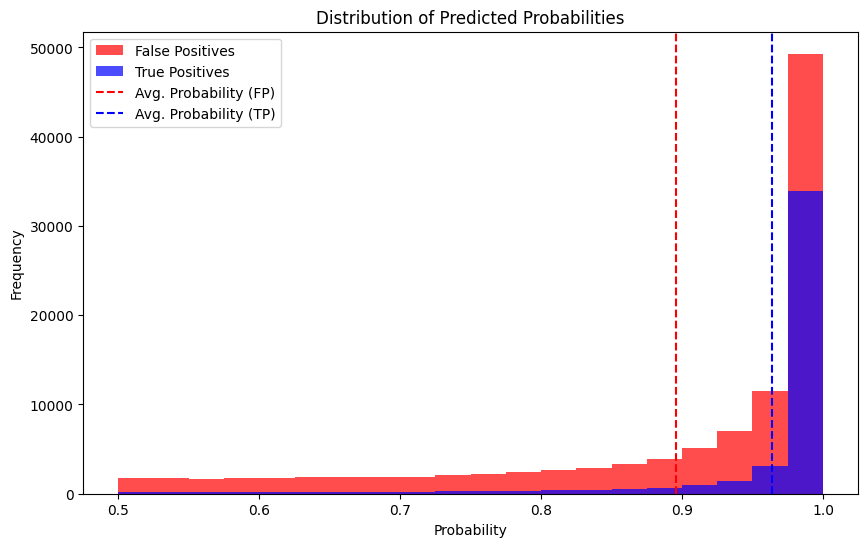

In [8]:
# graph with std dev
import matplotlib.pyplot as plt

# Plot the distribution of probabilities for false positives
plt.figure(figsize=(10, 6))
plt.hist(df_fp['probabilities'], bins=20, color='red', alpha=0.7, label='False Positives')
plt.hist(df_tp['probabilities'], bins=20, color='blue', alpha=0.7, label='True Positives')
plt.axvline(avg_prob_fp, color='red', linestyle='--', label='Avg. Probability (FP)')
plt.axvline(avg_prob_tp, color='blue', linestyle='--', label='Avg. Probability (TP)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

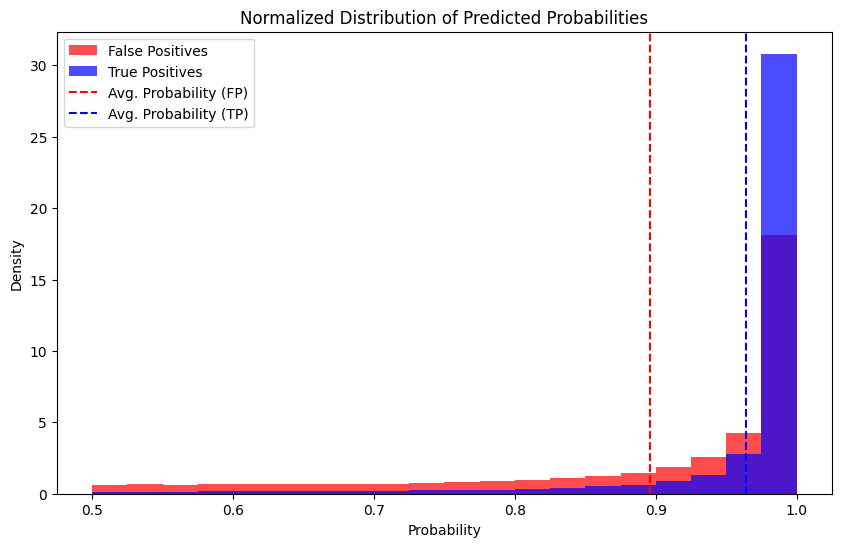

In [9]:
import matplotlib.pyplot as plt

# Normalize histograms by setting density=True
plt.figure(figsize=(10, 6))
plt.hist(df_fp['probabilities'], bins=20, color='red', alpha=0.7, label='False Positives', density=True)
plt.hist(df_tp['probabilities'], bins=20, color='blue', alpha=0.7, label='True Positives', density=True)
plt.axvline(avg_prob_fp, color='red', linestyle='--', label='Avg. Probability (FP)')
plt.axvline(avg_prob_tp, color='blue', linestyle='--', label='Avg. Probability (TP)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Normalized Distribution of Predicted Probabilities')
plt.legend()
plt.show()

/var/folders/0m/90sjqm9d78l50t2x2lmdrztm0000gn/T/ipykernel_85500/184577552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['label'] = 0  # False positives have label 0
/var/folders/0m/90sjqm9d78l50t2x2lmdrztm0000gn/T/ipykernel_85500/184577552.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tp['label'] = 1  # True positives have label 1


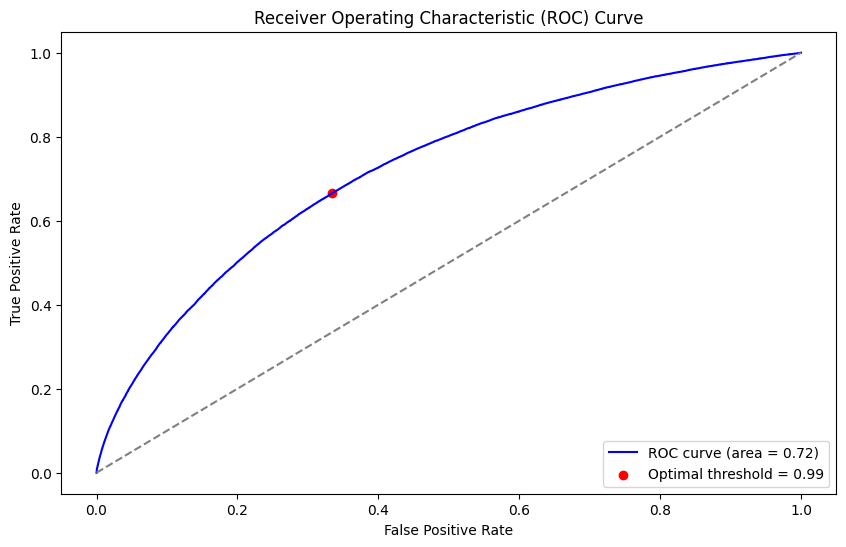

Optimal threshold based on Youden's J statistic: 0.99


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming df_fp and df_tp are your DataFrames with probabilities and labels
df_fp['label'] = 0  # False positives have label 0
df_tp['label'] = 1  # True positives have label 1

# Combine the DataFrames
df_combined = pd.concat([df_fp, df_tp])

# Sort by probabilities in descending order
df_combined = df_combined.sort_values(by='probabilities', ascending=False)

# Calculate true positive rate (TPR) and false positive rate (FPR) for each threshold
fpr, tpr, thresholds = roc_curve(df_combined['label'], df_combined['probabilities'])

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Optimal threshold based on Youden\'s J statistic: {optimal_threshold:.2f}')

In [11]:
# Apply the optimal threshold to the probabilities
df_combined['predicted'] = (df_combined['probabilities'] >= optimal_threshold).astype(int)
#recalculate tp, fp, tn, fn
df_combined['tp'] = (df_combined['label'] == 1) & (df_combined['predicted'] == 1)
df_combined['fp'] = (df_combined['label'] == 0) & (df_combined['predicted'] == 1)
df_combined['fn'] = (df_combined['label'] == 1) & (df_combined['predicted'] == 0)
df_combined['tn'] = (df_combined['label'] == 0) & (df_combined['predicted'] == 0)

# Calculate precision and recall
precision = df_combined['tp'].sum() / (df_combined['tp'].sum() + df_combined['fp'].sum())
recall = df_combined['tp'].sum() / (df_combined['tp'].sum() + df_combined['fn'].sum())

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 score: {f1:.2f}")

# Calculate accuracy
accuracy = (df_combined['tp'].sum() + df_combined['tn'].sum()) / len(df_combined)
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.45
Recall: 0.67
F1 score: 0.53
Accuracy: 0.67


In [12]:
# Another pro of colocalization is it narrows the space were looking at, we can just atac and chip for a single tf of interest
# would it be interesting to train a model on the places tp vs fp and see if we can predict the true positives, and still leave one cell line out